# Point Cloud Aggregation, Moving Object Filtering & Colorization

---

## Project Overview

This notebook implements an end-to-end 3D environment reconstruction pipeline using the **nuScenes dataset**, specifically focusing on:

1. **Point Cloud Aggregation**
2. **Moving Object Filtering (Static Map Extraction)**
3. **Camera-based Colorization of Static 3D Points**

The **Goal** is to build a high-quality static 3D map of an environment by combining:

- Top-mounted 360 degree LiDAR
- GNSS-INS ego-motion
- Extrinsic & intrinsic sensor calibration
- 6 synchronized RGB cameras

This produces a dense, consistent, and visually enriched 3D representation of the scene.

---

## Dataset Used: **[nuScenes (v1.0-mini)](https://nuscenes.org/nuscenes)**

We use the **mini split** of nuScenes for faster experimentation:

- 10 scenes
- Multimodal sensor suite
- Fully synchronized at **2Hz LiDAR / 12 Hz cameras**
- Includes:
    - `samples/`: keyframes
    - `sweeps/`: intermediate LiDAR frames
    - `calibrated_sensor.json`: sensor to ego transform
    - `ego_pose.json`: ego to world transforms
    - `camera images`
    - `LiDAR.pcd.bin files`

This gives all necessary metadata to reconstruct each LiDAR point into **world coordinates** and then project them onto camera images.

---

## Author:
**Name:** Priyam Gupta             
**Neptun Code:** KXHGEA

---

## Imports

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import time
import random

import open3d as o3d

from pathlib import Path
from collections import defaultdict, Counter
from PIL import Image

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Dataset Path Setup

`nuScenes` dataset is structured into three main directories:

- `samples/` : contains keyframe sensor data (LiDAR, cameras, radar)
- `sweeps/` : contains intermediate non-keyframe LiDAR sweeps
- `v1.0-mini/` : metadata JSON files (calibration, ego poses, sample_data links, etc.)

In [2]:
# Root directory of the dataset
DATASET_ROOT = Path('.') / 'dataset' / 'v1_0_mini'

# Subdirectories
JSON_ROOT = DATASET_ROOT / 'v1.0-mini'
SAMPLES_ROOT = DATASET_ROOT / 'samples'
SWEEPS_ROOT = DATASET_ROOT / 'sweeps'

# Verify the existence of the directories
print(f"DATASET_ROOT: {DATASET_ROOT.resolve()}\n")
print(f"JSON_ROOT exists: {JSON_ROOT.exists()}")
print(f"SAMPLES_ROOT exists: {SAMPLES_ROOT.exists()}")
print(f"SWEEPS_ROOT exists: {SWEEPS_ROOT.exists()}")

DATASET_ROOT: /home/priyam/ELTE_sem3/3d sensing and sensor fusion/point_cloud_aggregation_based_on_GPS_moving_object_filtering/dataset/v1_0_mini

JSON_ROOT exists: True
SAMPLES_ROOT exists: True
SWEEPS_ROOT exists: True


## Helper Functions

In [3]:
def load_json(fn):
    '''
        Load a JSON file and return the parsed data.

        Args:
            - fn: Path to the JSON file.

        Returns:
            - dict or list: Parsed JSON data.
    '''
    with open(fn, 'r') as f:
        return json.load(f)
    

def quat_to_rotmat(quaternion):
    '''
        Convert a quaternion into a 3x3 rotation matrix.

        Args:
            - quaternion: list or array of 4 elements [w, x, y, z].

        Returns:
            - R_mat: 3x3 numpy array representing the rotation matrix.
    '''
    # Ensure the quaternion is a numpy array
    quaternion = np.array(quaternion, dtype=np.float64)
    
    # Normalize the quaternion to ensure it's a unit quaternion
    quaternion = quaternion / np.linalg.norm(quaternion)  

    # Convert Quaternion to Rotation Matrix using Open3D
    R_mat = o3d.geometry.get_rotation_matrix_from_quaternion(quaternion)

    return R_mat


def transform_points(points, translation, rotation_q):
    '''
        Apply a rigid body transformation to a set of 3D points.

        The transformation consists of:
        1. Rotation defined by the quaternion.
        2. Translation defined by the translation vector.

        Args:
            - points: Nx3 numpy array of points.
            - translation: list or array of 3 elements [tx, ty, tz].
            - rotation_q: list or array of 4 elements [w, x, y, z].

        Returns:
            - transformed_points: Nx3 numpy array of transformed 3D points.
    '''
    # Convert quaternion to rotation matrix
    R = quat_to_rotmat(rotation_q)

    # Convert translation to numpy array
    t = np.array(translation, dtype=np.float64)

    # Transform: p' = R * p + T
    transformed = (R @ points.T).T + t
    return transformed


def load_lidar_pointcloud(path):
    '''
        Load a nuScenes lidar point cloud (.pcd.bin format).

        nuScenes LiDAR files may contain:
            - 4 channels: x, y, z, intensity
            - 5 channels: x, y, z, intensity, ring index

        This function auto-detects the correct number of channels.

        Args:
            - path: Path to the LiDAR .pcd.bin file.

        Returns:
            - arr: Nx4 or Nx5 numpy array of point cloud data.
    '''
    # Load the binary file as a flat array of float32
    arr = np.fromfile(path, dtype=np.float32)

    # Handle empty files
    if arr.size == 0:
        print(f"Warning: Empty point cloud file: {path}")
        return np.zeros((0, 4), dtype=np.float32)
    
    # Reshape based on detected number of channels count
    if arr.size % 5 == 0:
        print(f"Info: Point cloud file {path} has 5 channels, reshaping accordingly.")
        arr = arr.reshape((-1, 5))

    elif arr.size % 4 == 0:
        print(f"Info: Point cloud file {path} has 4 channels, reshaping accordingly.")
        arr = arr.reshape((-1, 4))

    else:
        # Unexpected number of channels, truncate excess values to make divisible by 5
        try:
            print(f"Info: Point cloud file {path} has unexpected number of channels")
            n = (arr.size // 5) * 5
            arr = arr[:n].reshape((-1, 5))
        
        except Exception:
            raise RuntimeError(f"Error: Cannot reshape point cloud file {path}, unexpected size {arr.size}")
        
    return arr


def sample_points(pts, max_points=20000, seed=0):
    '''
        Randomly downsample a point cloud to a maximum number of points for visualization.

        Args:
            - pts: Nx3 numpy array of 3D input points.
            - max_points: Maximum number of points to sample.
            - seed: Random seed for reproducibility.

        Returns:
            - sampled_pts: Mx3 numpy array of downsampled 3D points (M <= max_points).
    '''
    # Number of input points
    n = pts.shape[0]

    if n <= max_points:
        print(f"Point cloud has {n} points, no sampling needed.")
        return pts
    
    # Initialize random number generator
    rng = np.random.default_rng(seed)      

    # Choose unique indices without replacement
    indices = rng.choice(n, size=max_points, replace=False)

    sampled_pts = pts[indices]
    print(f"Point cloud has {n} points, sampled down to {max_points} points.")
    return sampled_pts

## Load nuScenes JSON metadata


In [5]:
'''
    Load all required nuScenes metadata JSON files and convert them into
    fast-lookup dictionaries indexed by the unique `token` field.

    nuScenes metadata structure:
    
    - sample_data.json       : All sensor measurements (LiDAR, cameras, radar)
    - ego_pose.json          : GNSS/INS poses (world position + quaternion)
    - calibrated_sensor.json : Extrinsics (sensor -> ego transformations)
    - sample.json            : Links scenes -> samples -> sample_data
    - scene.json             : List of scenes (each ~20s)
    - sensor.json            : Definitions of sensors (e.g., LIDAR_TOP)

    These files together provide everything required to:
        1. Transform LiDAR points -> ego frame -> world frame
        2. Retrieve synchronized camera frames for colorization
        3. Aggregate multimodal sensor information
'''
print(f"Loading JSON files from {JSON_ROOT}.\n")

# Define paths to all required JSON files
json_files = {
                'sample_data'       : JSON_ROOT / 'sample_data.json',
                'ego_pose'          : JSON_ROOT / 'ego_pose.json',
                'calibrated_sensor' : JSON_ROOT / 'calibrated_sensor.json',
                'sample'            : JSON_ROOT / 'sample.json',
                'scene'             : JSON_ROOT / 'scene.json',
                'sensor'            : JSON_ROOT / 'sensor.json'
            }

# Verify existence of all the loaded JSON files
for name, filepath in json_files.items():
    print(f"{name}: {filepath}, exists: {filepath.exists()}")

# Load JSON metadata into Python Lists
sample_data = load_json(json_files['sample_data'])
ego_pose = load_json(json_files['ego_pose'])
calibrated_sensor = load_json(json_files['calibrated_sensor'])
sample = load_json(json_files['sample'])
scene = load_json(json_files['scene'])
sensor = load_json(json_files['sensor'])

print("\nJSON files loaded successfully.\n")

# Converts lists into dictionaries keyed by each entry’s token so lookups are fast
sample_data_map = {entry['token']: entry for entry in sample_data}
ego_pose_map = {entry['token']: entry for entry in ego_pose}
calib_map = {entry['token']: entry for entry in calibrated_sensor}
sample_map = {entry['token']: entry for entry in sample}
scene_map = {entry['token']: entry for entry in scene}
sensor_map = {entry['token']: entry for entry in sensor}

print("Summary:")
print(f"sample_data: {len(sample_data)}, ego_pose: {len(ego_pose)}, calibrated_sensor: {len(calibrated_sensor)}")

Loading JSON files from dataset/v1_0_mini/v1.0-mini.

sample_data: dataset/v1_0_mini/v1.0-mini/sample_data.json, exists: True
ego_pose: dataset/v1_0_mini/v1.0-mini/ego_pose.json, exists: True
calibrated_sensor: dataset/v1_0_mini/v1.0-mini/calibrated_sensor.json, exists: True
sample: dataset/v1_0_mini/v1.0-mini/sample.json, exists: True
scene: dataset/v1_0_mini/v1.0-mini/scene.json, exists: True
sensor: dataset/v1_0_mini/v1.0-mini/sensor.json, exists: True

JSON files loaded successfully.

Summary:
sample_data: 31206, ego_pose: 31206, calibrated_sensor: 120


## 1. Point Cloud Aggregation

### 1.1. Identify all LiDAR sweeps for a single scene.

This block:

1. Selects a random scene
2. Iterates through all samples belonging to that scene
3. Looks up the `sample_data` entries for each sample
4. Filters and keeps only the entries from the `LIDAR_TOP` sensor
5. Records:
    - lidar_sd_tokens  (unique token for each LiDAR frame)
    - lidar_filenames  (path to .pcd.bin files)
    - timestamps       (LiDAR timestamps)

In [6]:
# All scene identifiers
scene_tokens = list(scene_map.keys())
print(f"Number of scenes in JSON: {len(scene_tokens)}\n")

# Choose a random scene to process
random_scene_token = random.choice(scene_tokens)
print(f"Selected random scene token: {random_scene_token}")

# Fetch the scene dictionary
selected_scene = scene_map[random_scene_token]             
print(f"Scene name: {selected_scene.get('name')}, | Number of samples: {selected_scene.get('nbr_samples')}\n")

# Retrieve the first sample in this scene (a scene is a linked list of samples)
first_sample_token = selected_scene['first_sample_token']

# -----------------------------------------------------------------------------------
'''
    Collect all sample tokens in this scene. 

    Each scene is a chain of samples linked by "next" pointers.
    We traverse the chain to collect sample tokens in chronological order.
'''
scene_sample_tokens = []                # ordered list of sample tokens
current_token = first_sample_token
step_counter = 0

while current_token:
    scene_sample_tokens.append(current_token)
    current_token = sample_map[current_token]['next']   # move to next sample
    step_counter += 1

    # nuScenes scenes never exceed 40 samples (20 seconds at 2 Hz)
    if step_counter > 2000:
        print("Warning: Unexpected sample chain length (>2000). Breaking to prevent infinite loop.")
        break

print(f"Collected {len(scene_sample_tokens)} samples for scene '{selected_scene.get('name')}'.\n")

# -----------------------------------------------------------------------------------
'''
    Build Reverse Lookup: sample_token -> list of sample_data tokens.

    sample_data.json contains all sensor readings (LiDAR, cameras, radar)
    Each sample has many sample_data entries (one per sensor)
'''
sample_token_to_sampledata = defaultdict(list)      # list of sample_data entries per sample_token

# Iterate through all sample_data entries to build the reverse mapping
for sd in sample_data:
    sample_token_to_sampledata[sd['sample_token']].append(sd)

print("Built reverse mapping: sample_token -> sample_data entries.\n")

# -----------------------------------------------------------------------------------
'''
    For each sample in the selected scene, find the LIDAR_TOP sample_data entry.
'''
lidar_sd_tokens = []            # List of LIDAR sample_data tokens for the scene
lidar_filenames = []            # Corresponding filenames
lidar_timestamps = []           # Corresponding timestamps


for sample_token in scene_sample_tokens:

    sample_data_entries = sample_token_to_sampledata[sample_token]

    for sd in sample_data_entries:

        # sample_data -> calibrated_sensor -> sensor -> channel (“LIDAR_TOP”)
        calib_info = calib_map[sd['calibrated_sensor_token']]
        sensor_token = calib_info['sensor_token']
        sensor_channel = sensor_map[sensor_token]['channel']

        # Keep only LiDAR_TOP measurements
        if sensor_channel == 'LIDAR_TOP':
            lidar_sd_tokens.append(sd['token'])
            lidar_filenames.append(sd['filename'])
            lidar_timestamps.append(sd['timestamp'])
            break           # skip other sensors for this sample

print(f"Number of LIDAR_TOP sweeps found: {len(lidar_sd_tokens)}.")

print("Example LIDAR files:")
for i, fname in enumerate(lidar_filenames[:5]):
    print(f"   {i}: {fname}")

Number of scenes in JSON: 10

Selected random scene token: cc8c0bf57f984915a77078b10eb33198
Scene name: scene-0061, | Number of samples: 39

Collected 39 samples for scene 'scene-0061'.

Built reverse mapping: sample_token -> sample_data entries.

Number of LIDAR_TOP sweeps found: 39.
Example LIDAR files:
   0: samples/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402927647951.pcd.bin
   1: sweeps/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402928047779.pcd.bin
   2: sweeps/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402928448094.pcd.bin
   3: sweeps/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402928847884.pcd.bin
   4: sweeps/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402929247684.pcd.bin


### 1.2. Load and visualize the First LiDAR sweep of the scene

In [27]:
def plot_lidar_topdown(
                        points_xyz, 
                        labels=None,
                        colors=None, 
                        sample_rates=None,
                        title="LiDAR Top-Down View",
                        figsize=(10, 10), 
                        point_size=0.3):
    '''
        Visualize a LiDAR point cloud from a bird's-eye (XY) perspective.

        Args:
            - points_xyz: Nx3 numpy array of 3D points.
            - labels (list): labels for legend
            - colors (list): colors for each cloud
            - sample_rates (list): integer subsampling steps
            - title (str): plot title
            - figsize (tuple): figure size
            - point_size (float): scatter point size
    '''
    plt.figure(figsize=figsize)

    num_sets = len(points_xyz)

    # Default styling
    if labels is None:
        labels = [f"Cloud {i}" for i in range(num_sets)]

    if colors is None:
        colors = [None] * num_sets   # matplotlib default

    if sample_rates is None:
        sample_rates = [1] * num_sets

    for pts, label, color, step in zip(points_xyz, labels, colors, sample_rates):

        pts_2d = pts[::step, :2]        # Extract X, Y for top-down view

        plt.scatter(
                        pts_2d[:,0],
                        pts_2d[:,1],
                        s=point_size,
                        alpha=0.7,
                        color=color,
                        label=label
                    )

    plt.title(title)
    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.axis("equal")
    plt.legend()
    plt.grid(True)
    plt.show()

First LIDAR file path: dataset/v1_0_mini/samples/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402927647951.pcd.bin
File exists: True

Info: Point cloud file dataset/v1_0_mini/samples/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402927647951.pcd.bin has 5 channels, reshaping accordingly.
Loaded LiDAR point cloud.
Point cloud shape: (34688, 5)


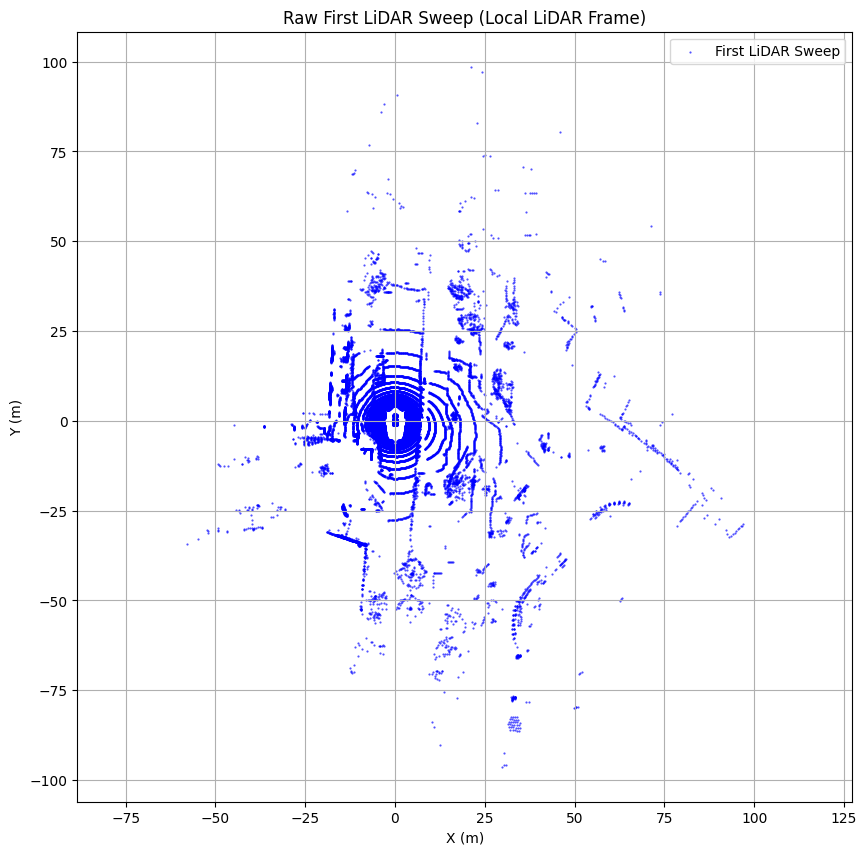

In [30]:
# Retrieve the first LIDAR file for the selected scene
first_lidar_filename = lidar_filenames[0]
first_lidar_path = DATASET_ROOT / first_lidar_filename

print(f"First LIDAR file path: {first_lidar_path}")
print(f"File exists: {first_lidar_path.exists()}\n")

# Load binary LiDAR point cloud (.pcd.bin)
first_lidar_raw = load_lidar_pointcloud(str(first_lidar_path))

print("Loaded LiDAR point cloud.")
print("Point cloud shape:", first_lidar_raw.shape)

# Extract XYZ coordinates (ignore intensity, ring index if present)
first_lidar_xyz = first_lidar_raw[:, :3]

# Visualize the sweep in LiDAR's local coordinate frame
plot_lidar_topdown(
                    points_xyz=[first_lidar_xyz],
                    labels=["First LiDAR Sweep"],
                    colors=["blue"],
                    sample_rates=[1],
                    title="Raw First LiDAR Sweep (Local LiDAR Frame)"
                )

### 1.3. Transform & Visualize a LiDAR Sweep from Sensor Frame -> Ego frame -> World frame

In [31]:
def points_sensor_to_world(points_sensor, sample_data_entry, calib_map, ego_pose_map):
    '''
        Transform points from a sensor-local frame into the global/world frame.

        This function performs the two-step transform that nuScenes uses:
            1) sensor -> ego (using calibrated_sensor entry)
            2) ego -> world (using ego_pose entry referenced by sample_data)

        Args:
            - points_sensor: Nx3 numpy array of points in the sensor frame.
            - sample_data_entry: sample_data dictionary entry for the sensor measurement.
            - calib_map: Dictionary mapping calibrated_sensor tokens to their entries.
            - ego_pose_map: Dictionary mapping ego_pose tokens to their entries.

        Returns:
            - pts_world: Nx3 numpy array of points in the global/world frame.
    '''
    # 1) Sensor -> Ego using calibrated sensor (translation, quaternion rotation)
    calib_entry = calib_map[sample_data_entry['calibrated_sensor_token']]
    
    sensor_to_ego_t = calib_entry['translation']   # [x, y, z]
    sensor_to_ego_q = calib_entry['rotation']      # quaternion [w, x, y, z]

    pts_ego = transform_points(points_sensor, sensor_to_ego_t, sensor_to_ego_q)

    # 2) Ego -> World using ego_pose (translation, quaternion rotation)
    ego_pose_entry = ego_pose_map[sample_data_entry['ego_pose_token']]
    ego_to_world_t = ego_pose_entry['translation']
    ego_to_world_q = ego_pose_entry['rotation']

    pts_world = transform_points(pts_ego, ego_to_world_t, ego_to_world_q)

    return pts_world

Transform LiDAR -> Ego -> World (example using first sweep)

Using sample_data token: 9d9bf11fb0e144c8b446d54a8a00184f
LiDAR filename: samples/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402927647951.pcd.bin

LiDAR -> Ego translation: [0.943713, 0.0, 1.84023]
LiDAR -> Ego rotation (quat): [0.7077955119163518, -0.006492242056004365, 0.010646214713995808, -0.7063073142877817]

Example (LiDAR_local -> world) for first 5 points:
  LiDAR: [-3.1243734  -0.43415368 -1.867192  ]  ->  World: [ 4.14086460e+02  1.17937830e+03 -6.90804743e-02]
  LiDAR: [-3.2906363  -0.43220678 -1.8631892 ]  ->  World: [ 4.14241928e+02  1.17931922e+03 -6.77048676e-02]
  LiDAR: [-3.47041    -0.43068862 -1.8595628 ]  ->  World: [ 4.14410229e+02  1.17925591e+03 -6.68980550e-02]
  LiDAR: [-3.6680946  -0.42834675 -1.8559859 ]  ->  World: [ 4.14595066e+02  1.17918567e+03 -6.64449746e-02]
  LiDAR: [-3.899638   -0.42564592 -1.8602061 ]  ->  World: [ 4.14811555e+02  1.17910377e+03 -7.43164350e-02]


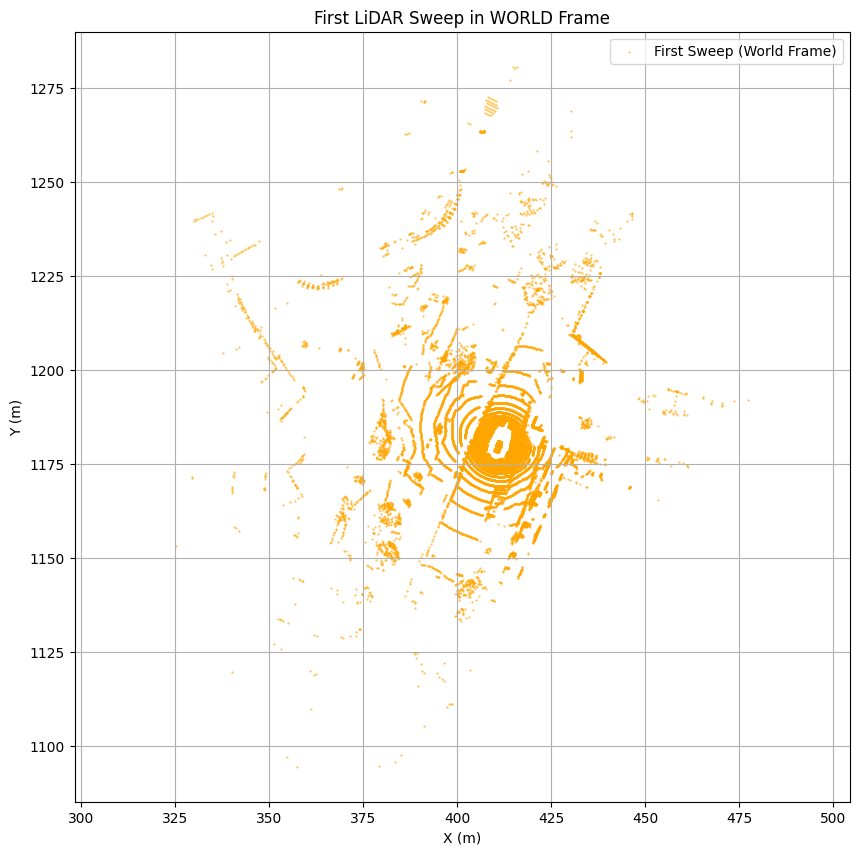

In [34]:
print("Transform LiDAR -> Ego -> World (example using first sweep)\n")

# Get the first LiDAR sample_data token and entry
lidar_sd_token = lidar_sd_tokens[0]
lidar_sd_entry = sample_data_map[lidar_sd_token]

print("Using sample_data token:", lidar_sd_token)
print(f"LiDAR filename: {lidar_sd_entry['filename']}\n")

# --------------------------------------------------
# A) LiDAR → EGO TRANSFORM
# --------------------------------------------------

calib_entry = calib_map[lidar_sd_entry['calibrated_sensor_token']]

lidar_to_ego_translation = calib_entry['translation']      # [x,y,z]
lidar_to_ego_rotation = calib_entry['rotation']            # quaternion [w,x,y,z]

print("LiDAR -> Ego translation:", lidar_to_ego_translation)
print("LiDAR -> Ego rotation (quat):", lidar_to_ego_rotation)

# Reuse the LiDAR points loaded earlier for this sweep - fist_lidar_raw
# Points in sensor local frame (LiDAR frame)
lidar_xyz = first_lidar_raw[:, :3]              # Nx3 LiDAR local frame

# Transform LiDAR points from LiDAR frame to world frame
lidar_pts_world = points_sensor_to_world(
                                            lidar_xyz, 
                                            lidar_sd_entry, 
                                            calib_map, 
                                            ego_pose_map
                                        )

# Print example transformations for first few points from LiDAR local to world
print("\nExample (LiDAR_local -> world) for first 5 points:")
for i in range(min(5, lidar_xyz.shape[0])):
    print(f"  LiDAR: {lidar_xyz[i]}  ->  World: {lidar_pts_world[i]}")

# Visualize LiDAR points in WORLD frame
plot_lidar_topdown(
                    points_xyz=[lidar_pts_world],
                    labels=["First Sweep (World Frame)"],
                    colors=["orange"],
                    sample_rates=[1],
                    title="First LiDAR Sweep in WORLD Frame"
                )


### 1.4. Aggregate all LiDAR sweeps into world frame

In [35]:
def aggregate_lidar_sweeps(lidar_sd_tokens, sample_data_map, calib_map, ego_pose_map, dataset_root):
    '''
        Aggregate all LiDAR sweeps for a selected scene into WORLD coordinates.

        This function:
            1. Loads each LiDAR sweep (.pcd.bin)
            2. Converts its points from LiDAR -> Ego -> World frame
            3. Stores per-sweep and aggregated world-frame point clouds

        Args:
            - lidar_sd_tokens: List of sample_data tokens corresponding to LIDAR_TOP sweeps.
            - sample_data_map: Dictionary mapping sample_data tokens to entries.
            - calib_map: Dictionary mapping calibrated_sensor tokens to entries.
            - ego_pose_map: Dictionary mapping ego_pose tokens to entries.
            - dataset_root: Path to the root of the dataset.

        Returns:
            - sweep_world_points: List of Nx3 numpy arrays (one per sweep) in world frame.
            - sweep_timestamps: List of timestamps corresponding to each sweep.
            - all_world_points: Mx3 numpy array of all aggregated points in world frame.
    '''
    sweep_world_points = []         # List of per-sweep world points
    sweep_timestamps = []           # List of per-sweep timestamps
    aggregated_list = []            # List to accumulate all world points

    print("Aggregating Per-Sweep World-Frame Point Clouds\n")

    # Process each LiDAR sweep
    for idx, sd_token in enumerate(lidar_sd_tokens):
        sd_entry = sample_data_map[sd_token]            # Get sample_data entry
        filename = sd_entry['filename']                 # LiDAR filename
        lidar_path = dataset_root / filename            # Full path to LiDAR file

        # Load LiDAR sweep point cloud
        lidar_raw = load_lidar_pointcloud(str(lidar_path))
        lidar_xyz = lidar_raw[:, :3]                    # Extract XYZ coordinates

        # Convert LiDAR points from sensor frame to world frame
        pts_world = points_sensor_to_world(lidar_xyz, sd_entry, calib_map, ego_pose_map)

        # Store results for this sweep
        sweep_world_points.append(pts_world)            # Per-sweep world points
        sweep_timestamps.append(sd_entry['timestamp'])  # Per-sweep timestamp
        aggregated_list.append(pts_world)               # Accumulate for overall aggregation

        # Progress update
        if idx % 10 == 0:
            print(f"\nProcessed {idx+1}/{len(lidar_sd_tokens)} sweeps")

    # Stack all sweeps into one large array
    all_world_points = np.vstack(aggregated_list)

    return sweep_world_points, sweep_timestamps, all_world_points

In [36]:
# Run aggregation
sweep_world_points, sweep_timestamps, all_world_points = aggregate_lidar_sweeps(
                                                                                    lidar_sd_tokens,
                                                                                    sample_data_map,
                                                                                    calib_map,
                                                                                    ego_pose_map,
                                                                                    DATASET_ROOT
                                                                                )

print("\nSweep Processing Complete:")
print("     Total sweeps processed:", len(sweep_world_points))
print("     Per-sweep point counts (first 5):", [pts.shape[0] for pts in sweep_world_points[:5]])
print("     Aggregated world cloud shape:", all_world_points.shape)


Aggregating Per-Sweep World-Frame Point Clouds

Info: Point cloud file dataset/v1_0_mini/samples/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402927647951.pcd.bin has 5 channels, reshaping accordingly.

Processed 1/39 sweeps
Info: Point cloud file dataset/v1_0_mini/sweeps/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402928047779.pcd.bin has 5 channels, reshaping accordingly.
Info: Point cloud file dataset/v1_0_mini/sweeps/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402928448094.pcd.bin has 5 channels, reshaping accordingly.
Info: Point cloud file dataset/v1_0_mini/sweeps/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402928847884.pcd.bin has 5 channels, reshaping accordingly.
Info: Point cloud file dataset/v1_0_mini/sweeps/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402929247684.pcd.bin has 5 channels, reshaping accordingly.
Info: Point cloud file dataset/v1_0_mini/sweeps/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__15324029

Point cloud has 1354208 points, sampled down to 100000 points.


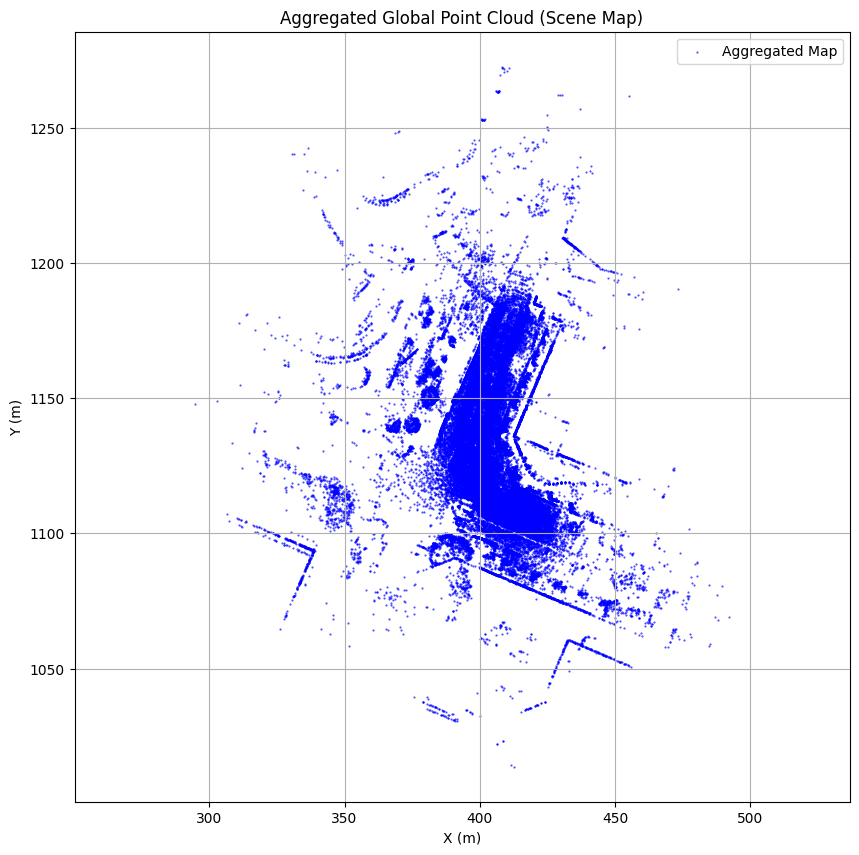

In [38]:
# Visualize aggregated map (subsampled)
sample_vis = sample_points(all_world_points, max_points=100000)

plot_lidar_topdown(
                    points_xyz=[sample_vis],            
                    labels=["Aggregated Map"],           
                    colors=["blue"],                         
                    sample_rates=[1],                       
                    title="Aggregated Global Point Cloud (Scene Map)"
                )

## 2. Moving Object Filtering

### 2.1. Global Configuration Parameters

In [48]:
MAX_SWEEPS = None               # If None => use all sweeps in scene; otherwise limit sweep

SAVE_OUTPUT_PLY = True          # Whether to save output point clouds as .ply files
OUT_DIR = Path('output')        
OUT_DIR.mkdir(exist_ok=True)

### 2.2. Stage 1: Temporal Consistency Filtering

Dynamic objects only appear in a small number of sweeps while Static structures (road,
buildings, poles, walls, sidewalks) appear repeatedly.

We assign each 3D voxel a **vote count = number of sweeps in which it appears**.        
Then we keep only voxels with `vote_count >= MIN_VOXEL_HIT_COUNT`.

In [47]:
# Temporal Consistency Filter Parameters

# Voxel size
VOXEL_SIZE = 0.3        # meters

# Minimum number of different LiDAR sweeps in which a voxel must appear to be considered 
# static. Dynamic objects appear in few sweeps, so this filter removes them.
MIN_VOXEL_HIT_COUNT = 3  

print("  Stage 1 - Temporal Consistency Filter:")
print(f"  VOXEL_SIZE = {VOXEL_SIZE}")
print(f"  MIN_SWEEP_OCCUPANCY = {MIN_VOXEL_HIT_COUNT}\n")

  Stage 1 - Temporal Consistency Filter:
  VOXEL_SIZE = 0.3
  MIN_SWEEP_OCCUPANCY = 3



In [40]:
def points_to_voxel_indices(points, origin, voxel_size):
    '''
        Convert 3D points into discrete voxel grid indices.

        Args:
            - points: Nx3 numpy array of 3D points.
            - origin: 3-element list or array specifying the origin of the voxel grid.
            - voxel_size: Size of each voxel in meters.

        Returns:
            - indices: Nx3 numpy array of voxel indices (integers).
    '''
    indices = np.floor((points - origin) / voxel_size).astype(np.int32)
    return indices

def voxel_tuple_array_to_strings(arr):
    '''
        Convert an array of voxel index tuples into string representations.

        Args:
            - arr: Nx3 numpy array of voxel indices.

        Returns:
            - list of strings: Each string represents a voxel index in the format "x,y,z".
    '''
    return [f"{x},{y},{z}" for (x, y, z) in arr]

In [41]:
# ---------------- Compute Voxel Occupancy Across Sweeps ------------------

print("Computing voxel occupancy across LiDAR sweeps.\n")

start_time = time.time()                 # timing

# Filter sweeps with 0 points (empty sweeps)
valid_sweeps = [pts for pts in sweep_world_points if pts.shape[0] > 0]

if len(valid_sweeps) == 0:
    raise RuntimeError("Error: No valid sweeps found.")

# Compute global bounding box across all sweeps (used to define voxel grid origin)
global_min = np.min([pts.min(axis=0) for pts in valid_sweeps], axis=0)      # Min corner    
global_max = np.max([pts.max(axis=0) for pts in valid_sweeps], axis=0)      # Max corner

print("Global bounding box:")
print(f"    min: {global_min}")
print(f"    max: {global_max}\n")

# Origin of voxel grid = minimum coordinate of scene
voxel_origin = global_min
voxel_size = VOXEL_SIZE

# Counter to track voxel occupancy across sweeps
voxel_occupancy_counter = Counter()
sweep_voxel_sets = []                   # Store which voxels each sweep touches

# Loop over sweeps
for sweep_idx, sweep_pts in enumerate(sweep_world_points):

    # Skip empty sweeps
    if sweep_pts.shape[0] == 0:
        sweep_voxel_sets.append(set())
        continue

    # Convert sweep points to voxel grid
    voxel_indices = points_to_voxel_indices(sweep_pts, voxel_origin, voxel_size)

    # Unique voxel hits for this sweep
    unique_voxels = np.unique(voxel_indices, axis=0)
    voxel_tuples = [tuple(v) for v in unique_voxels]

    # Count 1 vote per voxel per sweep
    for voxel_id in voxel_tuples:
        voxel_occupancy_counter[voxel_id] += 1

    sweep_voxel_sets.append(set(voxel_tuples))

    if sweep_idx % 5 == 0:
        print(f"Processed sweep {sweep_idx+1}/{len(sweep_world_points)} — "
              f"unique voxels: {len(unique_voxels)}")

end_time = time.time()

print(f"\nVoxel occupancy computed in {end_time - start_time:.2f}s")
print(f"Total unique voxels observed: {len(voxel_occupancy_counter)}")

Computing voxel occupancy across LiDAR sweeps.

Global bounding box:
    min: [ 292.1042651  1013.64436697  -30.39785824]
    max: [ 515.90014776 1280.67490679   24.20181499]

Processed sweep 1/39 — unique voxels: 9849
Processed sweep 6/39 — unique voxels: 8407
Processed sweep 11/39 — unique voxels: 9646
Processed sweep 16/39 — unique voxels: 9375
Processed sweep 21/39 — unique voxels: 9067
Processed sweep 26/39 — unique voxels: 8972
Processed sweep 31/39 — unique voxels: 9301
Processed sweep 36/39 — unique voxels: 9250

Voxel occupancy computed in 1.74s
Total unique voxels observed: 156888


Static voxels kept (hit_count ≥ 3): 41754

Voxel hit count statistics:
    min = 1
    max = 24
    median = 1.0
    mean = 2.293158176533578


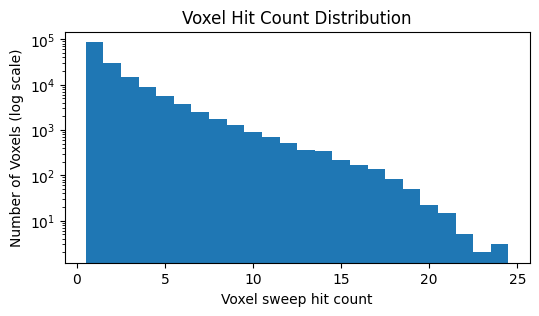

In [42]:
# Select Static Voxels using Voxel Hit Count Threshold

# A voxel is static if it appears in ≥ MIN_VOXEL_HIT_COUNT sweeps
kept_static_voxels = {
    v for v, count in voxel_occupancy_counter.items()
    if count >= MIN_VOXEL_HIT_COUNT
}

print(f"Static voxels kept (hit_count ≥ {MIN_VOXEL_HIT_COUNT}): {len(kept_static_voxels)}\n")

# Statistics of voxel hit counts
voxel_hits = np.array(list(voxel_occupancy_counter.values()))

print("Voxel hit count statistics:")
print(f"    min = {voxel_hits.min()}")
print(f"    max = {voxel_hits.max()}")
print(f"    median = {np.median(voxel_hits)}")
print(f"    mean = {voxel_hits.mean()}")

# Show histogram of voxel hit counts
plt.figure(figsize=(6,3))
plt.hist(voxel_hits, bins=np.arange(1, voxel_hits.max()+2)-0.5, log=True)
plt.xlabel("Voxel sweep hit count")
plt.ylabel("Number of Voxels (log scale)")
plt.title("Voxel Hit Count Distribution")
plt.show()


Filtering aggregated points based on kept static voxels.

Total aggregated points: (1354208, 3)

Static points after Stage 1 filtering: (789030, 3)
Fraction retained: 58.27%



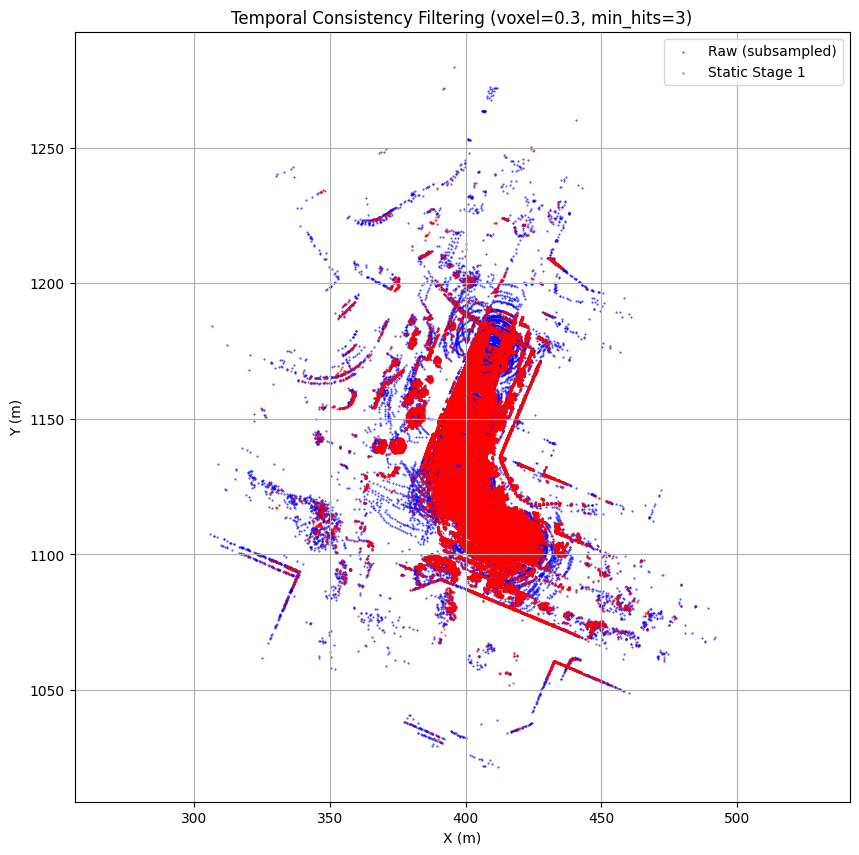

Stage 1 static PLY saved to: output/static_stage1_vox_0.30.ply


In [58]:
# Filter Aggregated Points using Static Voxels

print("Filtering aggregated points based on kept static voxels.\n")

# Stack all sweeps into one large array
all_points_world = np.vstack([pts for pts in sweep_world_points if pts.shape[0] > 0])
print(f"Total aggregated points: {all_points_world.shape}\n")

# Convert all points to voxel indices
all_voxel_indices = points_to_voxel_indices(all_points_world, voxel_origin, voxel_size)

# Fast vectorized matching using structured array trick
kept_voxel_arr = np.array(list(kept_static_voxels), dtype=np.int32)

if kept_voxel_arr.size == 0:
    print("Warning: No static voxels found. Output will be empty.")
    stage1_mask = np.zeros(all_points_world.shape[0], dtype=bool)

else:
    dtype = np.dtype((np.void, kept_voxel_arr.dtype.itemsize * 3))
    
    # Create views for comparison
    kept_view = kept_voxel_arr.view(dtype).ravel()                           
    inds_view = np.ascontiguousarray(all_voxel_indices).view(dtype).ravel()    
    
    # Create mask of points to keep 
    stage1_mask = np.in1d(inds_view, kept_view)

# Extract points belonging to static voxels
static_points_stage1 = all_points_world[stage1_mask]

print(f"Static points after Stage 1 filtering: {static_points_stage1.shape}")
print("Fraction retained:",
      f"{100.0 * static_points_stage1.shape[0] / all_points_world.shape[0]:.2f}%\n")


# Visualization & Saving
plot_lidar_topdown(
    points_xyz=[all_points_world, static_points_stage1],
    labels=["Raw (subsampled)", "Static Stage 1"],
    colors=["blue", "red"],
    sample_rates=[10, 4],
    title=f"Temporal Consistency Filtering (voxel={voxel_size}, min_hits={MIN_VOXEL_HIT_COUNT})"
)

# Save static output to PLY
pcd_stage1 = o3d.geometry.PointCloud()
pcd_stage1.points = o3d.utility.Vector3dVector(static_points_stage1)

out_file = OUT_DIR / f"static_stage1_vox_{voxel_size:.2f}.ply"
o3d.io.write_point_cloud(str(out_file), pcd_stage1)
print(f"Stage 1 static PLY saved to: {out_file}")


### 2.3. Stage 2: Spatial Filtering Using DBSCAN

After **Stage 1 (Temporal Consistency Filtering)**, we have a point cloud where most moving objects are removed by enforcing voxel-level stability across multiple sweeps.

However, some noise and small dynamic fragments may still remain.  

To clean these, we apply **DBSCAN clustering**:

#### Why DBSCAN?
- It groups spatially connected points.
- Clusters that are too small are likely noise or dynamic artifacts.
- It is robust to irregular, non-uniform point distributions.

#### Stage 2 Pipeline:
1. Convert Stage-1 static points to an Open3D point cloud.
2. Run DBSCAN with suitable spatial radius (`eps`) and density threshold (`min_points`).
3. Remove clusters smaller than a configured `min_cluster_size`.
4. Save and visualize the cleaned static map.

This produces a much cleaner static environment representation.

In [50]:
# DBSCAN Parameters (tunable)

DBSCAN_EPS = 0.6           # Radius (meters) for neighborhood search
DBSCAN_MIN_POINTS = 15     # Min neighbors required to form a cluster
MIN_CLUSTER_SIZE = 150     # Remove clusters smaller than this

print("  Stage 2 - DBSCAN Clustering based Filter:")
print(f"  DBSCAN_EPS = {DBSCAN_EPS}")
print(f"  DBSCAN_MIN_POINTS = {DBSCAN_MIN_POINTS}")
print(f"  MIN_CLUSTER_SIZE = {MIN_CLUSTER_SIZE}\n")

  Stage 2 - DBSCAN Clustering based Filter:
  DBSCAN_EPS = 0.6
  DBSCAN_MIN_POINTS = 15
  MIN_CLUSTER_SIZE = 150



Spatial Filtering using DBSCAN Clustering

Running DBSCAN...

Precompute neighbors.[========================================] 100%
Clustering[=======================================>] 97%
DBSCAN clusters found: 375

Stage-2 static cloud size: (768177, 3)
Fraction retained after DBSCAN: 97.36%


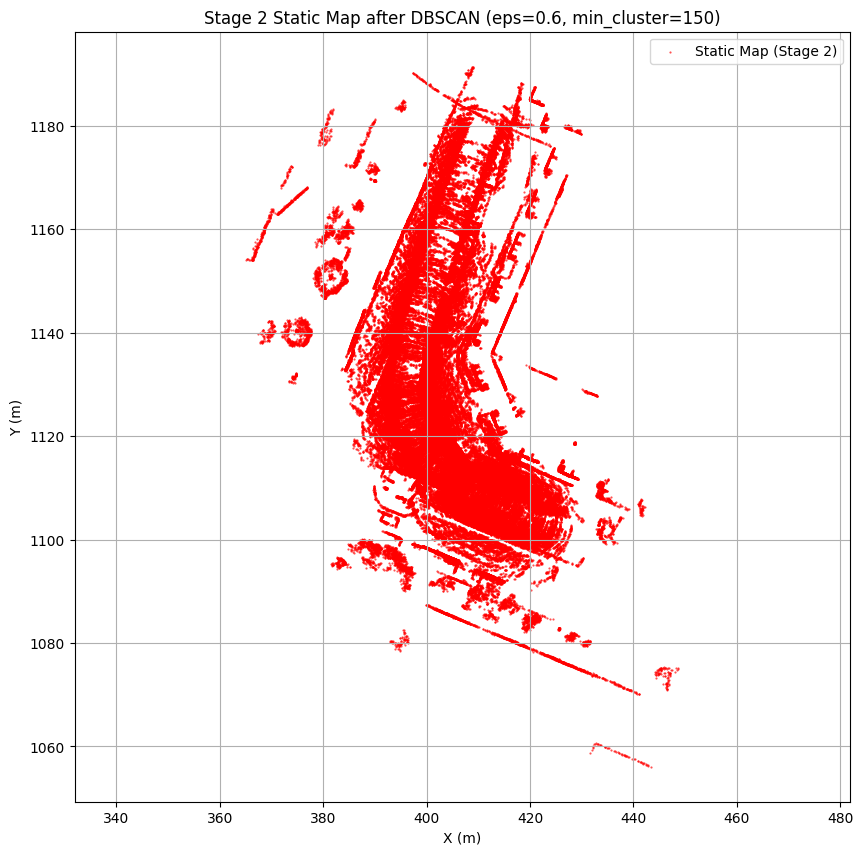

Saved Stage-2 filtered static map to: output/static_stage2_DBSCAN.ply


In [59]:
print("Spatial Filtering using DBSCAN Clustering\n")

# Convert Stage-1 static points to an Open3D point cloud
pcd_stage1 = o3d.geometry.PointCloud()
pcd_stage1.points = o3d.utility.Vector3dVector(static_points_stage1)

print("Running DBSCAN...\n")

# Run DBSCAN clustering
cluster_labels = np.array(
                            pcd_stage1.cluster_dbscan(
                                                        eps=DBSCAN_EPS,
                                                        min_points=DBSCAN_MIN_POINTS,
                                                        print_progress=True
                                                    )
                        )

num_clusters = cluster_labels.max() + 1
print(f"\nDBSCAN clusters found: {num_clusters}")

# Count how many points each cluster contains
cluster_sizes = np.bincount(cluster_labels[cluster_labels >= 0])

# Remove small clusters
min_cluster_size = 150    # (tune this)

# Keep clusters with sufficient size only
valid_clusters = set(np.where(cluster_sizes >= MIN_CLUSTER_SIZE)[0])

# Build mask selecting points belonging to valid clusters
stage2_mask = np.array([label in valid_clusters for label in cluster_labels])

# Extract cleaned static cloud
static_pts_stage2 = static_points_stage1[stage2_mask]

print("\nStage-2 static cloud size:", static_pts_stage2.shape)
print(
    "Fraction retained after DBSCAN: {:.2f}%".format(
        100.0 * static_pts_stage2.shape[0] / static_points_stage1.shape[0]
    )
)

# Visualization
plot_lidar_topdown(
    points_xyz=[static_pts_stage2],
    labels=["Static Map (Stage 2)"],
    colors=["red"],
    sample_rates=[4],                      # subsampling for visualization
    title=f"Stage 2 Static Map after DBSCAN (eps={DBSCAN_EPS}, min_cluster={MIN_CLUSTER_SIZE})"
)

# Save output as PLY
pcd_stage2 = o3d.geometry.PointCloud()
pcd_stage2.points = o3d.utility.Vector3dVector(static_pts_stage2)

output_path = OUT_DIR / "static_stage2_DBSCAN.ply"
o3d.io.write_point_cloud(str(output_path), pcd_stage2)

print(f"Saved Stage-2 filtered static map to: {output_path}")


## 3. Point Cloud Colorization 

Once moving objects are removed (Stages 1 & 2), we have a *clean static 3D map*.  
We now **project each static LiDAR point into the nearest camera images and sample its RGB color**.

### Why Colorize the 3D Map?

Colorization allows:
- Better visualization and interpretability  
- Semantic clues (roads, sidewalks, vegetation, cars…)  

### Colorization Pipeline

For every LiDAR sweep:

1. Identify **static points** captured in that sweep.  
2. For each point:
   - Transform from **world -> ego -> camera** frame  
   - Project to **2D image plane using camera intrinsics**  
   - Check if projection is **within camera bounds**  
3. Sample pixel RGB value  
4. Assign the color to the 3D point  
5. Prefer camera ordering:
   - **Front -> Left -> Right -> Back**  
   Because points are more likely visible in front-facing cameras.

Finally:
- Save the colored static point cloud as a PLY file  
- Visualize using Open3D  

In [62]:
# Rebuild all_pts (stack of all sweeps) and sweep_ids (origin of each point)
all_pts = []
sweep_ids = []   # for each point index, which sweep it came from (0..N-1)

for sweep_idx, sweep_points in enumerate(sweep_world_points):
    if sweep_points.shape[0] == 0:
        continue
    all_pts.append(sweep_points)
    sweep_ids.append(np.full(sweep_points.shape[0], sweep_idx, dtype=np.int32))

all_pts = np.vstack(all_pts)
sweep_ids = np.concatenate(sweep_ids)

print(f"Reconstructed all_pts: {all_pts.shape}")
print(f"Reconstructed sweep_ids: {sweep_ids.shape}\n")

# Build static mask for all_pts using earlier Stage 1 + Stage 2 masks
try:
    # Stage-1 mask is over ALL aggregated points
    final_mask = np.zeros_like(stage1_mask, dtype=bool)

    # Indices of points marked static in Stage-1
    stage1_indices = np.where(stage1_mask)[0]

    # Stage-2 mask is over static_points_stage1 only, so re-map it:
    final_static_indices = stage1_indices[stage2_mask]

    # Mark these points as static in the global mask
    final_mask[final_static_indices] = True

    static_mask = final_mask
    print("Static mask reconstructed from Stage-1 + Stage-2 masks.")

except Exception:
    # Fallback: exact match lookup using KDTree
    print("Masks not found — using KDTree fallback to locate static points.")
    from sklearn.neighbors import KDTree
    tree = KDTree(static_pts_stage2)
    dist, idx = tree.query(all_pts, k=1)
    static_mask = (dist[:, 0] < 1e-6)
    print("Static points detected:", static_mask.sum())

num_static_total = static_mask.sum()
print("\nTotal static points:", num_static_total)

Reconstructed all_pts: (1354208, 3)
Reconstructed sweep_ids: (1354208,)

Static mask reconstructed from Stage-1 + Stage-2 masks.

Total static points: 768177


In [63]:
# Build mapping: sample_token -> dict(camera_channel -> sample_data entry)

sample_to_channel_sd = defaultdict(dict)

# Build sensor_token -> channel mapping
sensor_token_to_channel = {s["token"]: s["channel"] for s in sensor}

# Iterate through all sample_data entries
for sd in sample_data:
    calibrated = calib_map[sd["calibrated_sensor_token"]]
    sensor_token = calibrated["sensor_token"]
    channel = sensor_token_to_channel[sensor_token]
    sample_to_channel_sd[sd["sample_token"]][channel] = sd

print("Built fast lookup: sample -> {camera_channel -> sample_data}")

# Define camera priority ordering to pick best colors first
camera_priority = [
    "CAM_FRONT", "CAM_FRONT_LEFT", "CAM_FRONT_RIGHT",
    "CAM_BACK", "CAM_BACK_LEFT", "CAM_BACK_RIGHT"
]

Built fast lookup: sample -> {camera_channel -> sample_data}


In [68]:
def project_world_points_to_image(
        points_world,
        ego_pose_entry,
        cam_calib_entry,
        cam_intrinsic,
        img_width,
        img_height,
        depth_threshold=0.1
    ):
    '''
        Transform 3D points from WORLD -> EGO -> CAMERA frame 
        and project them into pixel coordinates.

        Args:
            - points_world: Nx3 numpy array of 3D points in WORLD frame.
            - ego_pose_entry: Dictionary entry from ego_pose.json for the vehicle pose.
            - cam_calib_entry: Dictionary entry from calibrated_sensor.json for the camera.
            - cam_intrinsic: 3x3 camera intrinsic matrix.
            - img_width: Width of the camera image in pixels.
            - img_height: Height of the camera image in pixels.
            - depth_threshold: Minimum Z distance in camera frame to consider valid.

        Returns:
            - u: N-element array of pixel x-coordinates.
            - v: N-element array of pixel y-coordinates.
            - valid_mask: N-element boolean array indicating valid projections.
            - p_cam: Nx3 numpy array of points in CAMERA frame.
    '''

    # WORLD -> EGO 
    R_e_w = quat_to_rotmat(ego_pose_entry["rotation"])
    t_e_w = np.array(ego_pose_entry["translation"], dtype=np.float64)

    p_ego = (R_e_w.T @ (points_world.T - t_e_w.reshape(3, 1))).T

    # EGO -> CAMERA 
    R_s_e = quat_to_rotmat(cam_calib_entry["rotation"])
    t_s_e = np.array(cam_calib_entry["translation"], dtype=np.float64)

    p_cam = (R_s_e.T @ (p_ego.T - t_s_e.reshape(3, 1))).T

    # Depth validity check
    z = p_cam[:, 2]
    valid_z = z > depth_threshold

    # Camera Intrinsics
    K = np.array(cam_intrinsic, dtype=np.float64)

    # Project to pixel coordinates
    uv = (K @ p_cam.T).T
    u = uv[:, 0] / uv[:, 2]
    v = uv[:, 1] / uv[:, 2]

    # Points must project inside image boundaries
    in_bounds = (
        (u >= 0) & (u < img_width) &
        (v >= 0) & (v < img_height)
    )

    # Combine validity masks
    valid_mask = valid_z & in_bounds

    return u, v, valid_mask, p_cam

In [69]:
# -------------------------- Per-Sweep Color Assignment --------------------------

print("Starting per-sweep color assignment to static points.\n")

# Initialize colors array (default gray) and colored mask
colors = np.full((all_pts.shape[0], 3), 127, dtype=np.uint8)    # default gray color
colored_mask = np.zeros(all_pts.shape[0], dtype=bool)           # track which points have been colored

# Indices of static points
static_indices = np.where(static_mask)[0]
print(f"Static points to color: {static_indices.shape[0]}")

start_time = time.time()

# Precompute per-sweep indices of static points
sweep_to_static_indices = defaultdict(list)
for idx in static_indices:
    sweep_to_static_indices[sweep_ids[idx]].append(idx)

# ------------------------ Main colorization loop ------------------------
for sweep_idx, sweep_points in enumerate(sweep_world_points):

    # skip sweeps without static points
    if sweep_idx not in sweep_to_static_indices:
        continue

    pt_indices = np.array(sweep_to_static_indices[sweep_idx], dtype=np.int32)   # global point indices
    pts_world = all_pts[pt_indices]                                             # corresponding world points

    lidar_sd = sample_data_map[lidar_sd_tokens[sweep_idx]]                      # Get LiDAR sample_data entry
    sample_token = lidar_sd["sample_token"]                                     # Get sample token

    cam_entries = sample_to_channel_sd[sample_token]                            # Get camera sample_data entries for this sample
    if not cam_entries:
        continue

    # Try cameras in priority order
    for cam in camera_priority:
        if cam not in cam_entries:
            continue

        cam_sd = cam_entries[cam]                                               # Get sample_data entry for this camera
        cam_calib = calib_map[cam_sd["calibrated_sensor_token"]]                # Get calibrated_sensor entry
        
        # Camera intrinsics
        cam_intr = cam_calib.get("camera_intrinsic", None)
        if cam_intr is None:
            print(f"Missing intrinsics for {cam}")
            continue

        K = np.array(cam_intr, dtype=np.float64)                                # Camera intrinsic matrix

        # Image properties
        img_w = cam_sd["width"]
        img_h = cam_sd["height"]

        # Load image
        img_path = DATASET_ROOT / cam_sd["filename"]
        if not img_path.exists():
            continue

        img = np.array(Image.open(str(img_path)))

        u, v, valid_mask_proj, p_cam = project_world_points_to_image(
                                                                        pts_world,
                                                                        ego_pose_map[lidar_sd["ego_pose_token"]],
                                                                        cam_calib,
                                                                        cam_intr,
                                                                        img_w,
                                                                        img_h
                                                                    )
        not_yet_colored = ~colored_mask[pt_indices]                             # only color uncolored points

        valid = valid_mask_proj & not_yet_colored
        valid_idx = np.where(valid)[0]

        if valid_idx.size > 0:
            u_pix = np.clip(u[valid_idx].round().astype(int), 0, img_w-1)
            v_pix = np.clip(v[valid_idx].round().astype(int), 0, img_h-1)

            sampled_rgb = img[v_pix, u_pix, :3]
            global_indices = pt_indices[valid_idx]

            colors[global_indices] = sampled_rgb
            colored_mask[global_indices] = True

    # periodic debug output
    if sweep_idx % 5 == 0:
        print(f"Sweep {sweep_idx+1}/{len(sweep_world_points)} done — "
              f"colored {colored_mask.sum()} / {num_static_total}")

elapsed = time.time() - start_time
print(f"\nColorization complete in {elapsed:.2f}s")
print(f"Colored points: {colored_mask.sum()} / {num_static_total} "
      f"({100.0 * colored_mask.sum()/num_static_total:.2f}%)")


Starting per-sweep color assignment to static points.

Static points to color: 768177
Sweep 1/39 done — colored 6322 / 768177
Sweep 6/39 done — colored 59686 / 768177
Sweep 11/39 done — colored 126015 / 768177
Sweep 16/39 done — colored 193166 / 768177
Sweep 21/39 done — colored 263866 / 768177
Sweep 26/39 done — colored 340792 / 768177
Sweep 31/39 done — colored 420462 / 768177
Sweep 36/39 done — colored 499359 / 768177

Colorization complete in 2.15s
Colored points: 540010 / 768177 (70.30%)


In [70]:
# Build final colored static point cloud
static_global_indices = np.where(static_mask)[0]
final_pts = all_pts[static_global_indices]

final_colors = np.full((final_pts.shape[0], 3), 127, dtype=np.uint8)
global_to_local = {g:i for i, g in enumerate(static_global_indices)}

# Assign colors to final static points
for g in np.where(colored_mask)[0]:
    if g in global_to_local:
        final_colors[global_to_local[g]] = colors[g]

In [71]:
# Save and visualize colored cloud

output_color_pcd = o3d.geometry.PointCloud()
output_color_pcd.points = o3d.utility.Vector3dVector(final_pts)
output_color_pcd.colors = o3d.utility.Vector3dVector(final_colors.astype(float) / 255.0)

output_path = OUT_DIR / "static_colored_stage3.ply"
o3d.io.write_point_cloud(str(output_path), output_color_pcd)

print(f"Saved final colored map to: {output_path}")

print("Opening Open3D viewer...")
o3d.visualization.draw_geometries(
    [output_color_pcd],
    window_name="Colored Static Point Cloud",
    width=1200,
    height=800
)

Saved final colored map to: output/static_colored_stage3.ply
Opening Open3D viewer...
